# AG news分类
### 导入库

In [8]:
# 数据操作
import pandas as pd
import numpy as np

# 数据可视化
import matplotlib.pyplot as plt
import seaborn as sns  

# 终端输出文本着色
from termcolor import colored

# 划分训练集和测试集
from sklearn.model_selection import train_test_split

# 模型评估指标
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

# 使用 TensorFlow 和 Keras 进行深度学习
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 文本预处理
import re  # 正则表达式，用于清理文本
import string  # 字符串处理
from nltk.corpus import stopwords  # 停用词
from nltk.stem import PorterStemmer  # 词干提取器


### 导入数据集

In [3]:
# 读取训练和测试数据
train_data = pd.read_csv('ag_news_csv/train.csv', header=None, names=['ID', 'Title', 'Desc'])
test_data = pd.read_csv('ag_news_csv/test.csv', header=None, names=['ID', 'Title', 'Desc'])

# 合并标题和描述，作为模型的输入特征
X_train = train_data['Title'] + " " + train_data['Desc']
y_train = train_data['ID'].apply(lambda x: x - 1).values  # 类别从0开始

X_test = test_data['Title'] + " " + test_data['Desc']
y_test = test_data['ID'].apply(lambda x: x - 1).values  # 类别从0开始



训练数据集

In [4]:
train_data.head()


,ID,Title,Desc
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


测试数据集

In [5]:
test_data.head()

,ID,Title,Desc
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


### 数据集统计信息
数据集大小

In [6]:
print(train_data.shape)
print(test_data.shape)

(120000, 3)
(7600, 3)


训练集各类别大小

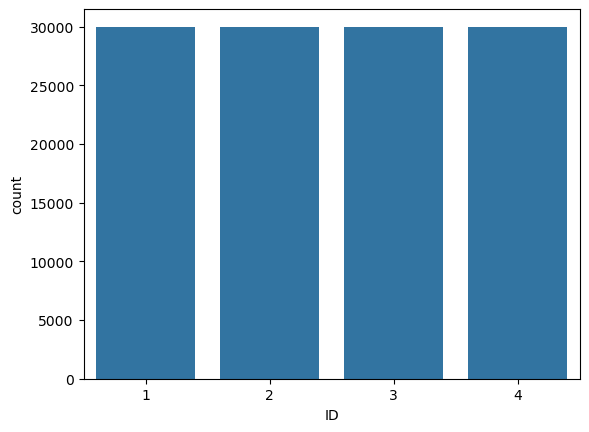

In [9]:
sns.countplot(x = 'ID', data = train_data)
plt.show()

测试集各类别大小

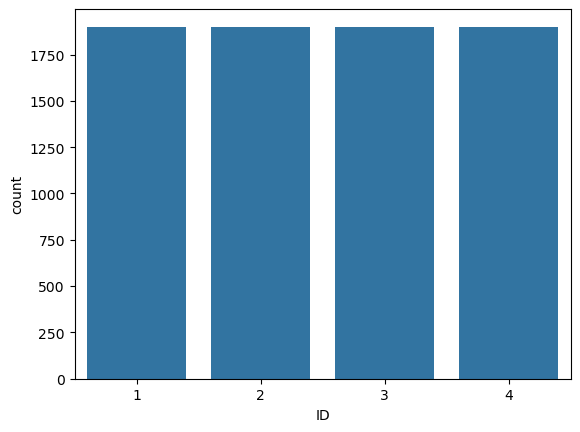

In [10]:
sns.countplot(x = 'ID', data = test_data)
plt.show()

各类别词云统计

In [31]:
train_x = train_data.Desc
test_x = test_data.Desc
train_y = train_data.ID
test_y = test_data.ID

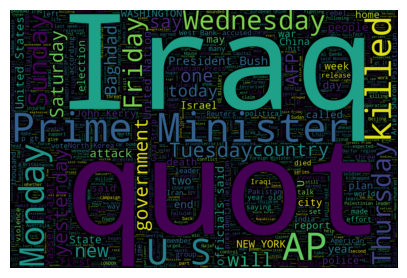

In [32]:
world = train_data[train_data['ID'] == 1]['Desc']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(world))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

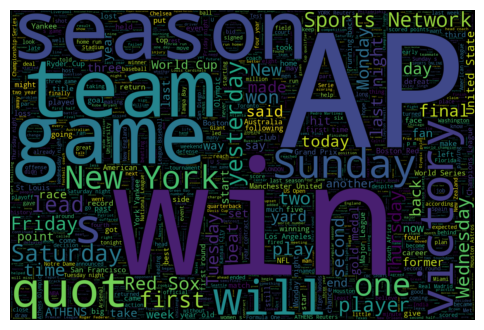

In [10]:
sports_desc = train_data.loc[train_data['ID'] == 2, 'Desc']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sports_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

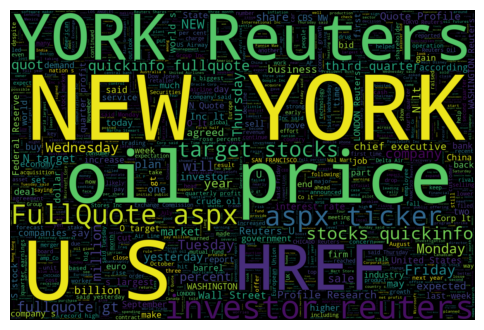

In [11]:
biz_desc = train_data.loc[train_data['ID'] == 3, 'Desc']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(biz_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

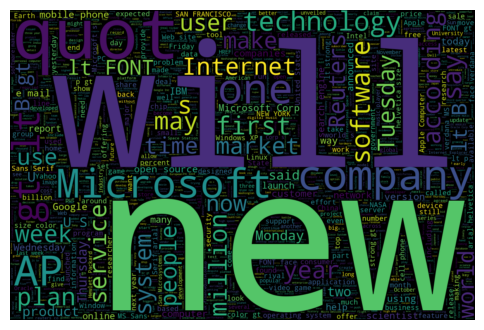

In [12]:
sci_desc = train_data.loc[train_data['ID'] == 4, 'Desc']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sci_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 数据清理

In [11]:

def remove_html_tag(text):
    html = re.compile('<.*?>')  # 修改正则表达式以匹配完整的HTML标签
    # print(html)
    cleaned_text = html.sub('', text)
    return cleaned_text

X_train = X_train.apply(remove_html_tag)
X_test = X_test.apply(remove_html_tag)


In [12]:
def url_remove(text):
    # 正则表达式匹配以 http 或 https 开头的 URL 和以 www 开头的 URL
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)  # 用空字符串替换 URL

# 应用 url_remove 函数
X_train = X_train.apply(url_remove)
X_test = X_test.apply(url_remove)

In [13]:
def word_tokenize(text):
    # 使用正则表达式匹配单词，包括字母、数字和撇号
    token = re.findall(r"[\w']+", text)
    return token  # 返回分词列表

# 应用 word_tokenize 函数
X_train = X_train.apply(word_tokenize)
X_test = X_test.apply(word_tokenize)

In [14]:
# 将单词转换为小写
X_train = X_train.apply(lambda x: [word.lower() for word in x])
X_test = X_test.apply(lambda x: [word.lower() for word in x])

In [15]:
def remove_stopwords(lst):
    stop_words = set(stopwords.words('english'))  # 获取英文停用词
    return [word for word in lst if word.lower() not in stop_words]  # 移除停用词

# import nltk
# nltk.download('stopwords')

# 应用 remove_stopwords 函数
X_train = X_train.apply(remove_stopwords)
X_test = X_test.apply(remove_stopwords)

In [16]:
def remove_extra_words(word_list):
    # 自定义停用词列表
    stopwords = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com']
    cleaned_list = [word for word in word_list if word not in stopwords]  # 移除停用词
    return cleaned_list

# 应用 remove_extra_words 函数
X_train = X_train.apply(remove_extra_words)
X_test = X_test.apply(remove_extra_words)



In [17]:
def join_words_with_space(sentence):
    # 将单词列表用空格拼接成字符串
    joined_sentence = ' '.join(sentence)
    return joined_sentence

# 应用 join_words_with_space 函数
X_train = X_train.apply(join_words_with_space)
X_test = X_test.apply(join_words_with_space)

In [18]:
# 计算训练数据集中句子的最大长度
maxlen = X_train.map(lambda x: len(x.split())).max()

# 句子最大长度
print("Max sentence length in training data:", maxlen)

Max sentence length in training data: 113


## 对文本数据进行分词、编码和填充

In [19]:
# 词汇表和嵌入层的维度
vocab_size = 10000  # 自定义词汇量大小
embed_size = 32     # 嵌入层维度

# 创建并拟合分词器
tok = Tokenizer(num_words=vocab_size)
tok.fit_on_texts(X_train.values)

# 将文本数据转换为序列
X_train = tok.texts_to_sequences(X_train)
x_test = tok.texts_to_sequences(X_test)

# 填充序列
X_train = pad_sequences(X_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)


## 网络架构 双向LSTM

In [22]:
# 模型初始化
model = Sequential()

# 1. 嵌入层：用于将单词索引映射为固定大小的向量
model.add(Embedding(vocab_size, embed_size, input_length=maxlen))  
# `vocab_size` 是词汇表大小，`embed_size` 是嵌入维度，`input_length` 是输入序列的最大长度

# 2. 双向 LSTM 层：第一个双向 LSTM 层，隐藏单元数为 128，并返回所有时间步的序列
model.add(Bidirectional(LSTM(128, return_sequences=True)))  

# 3. 双向 LSTM 层：第二个双向 LSTM 层，隐藏单元数为 64，并返回所有时间步的序列
model.add(Bidirectional(LSTM(64, return_sequences=True)))

# 4. 全局最大池化层：对 LSTM 输出进行池化，减少特征的敏感性并增加泛化能力
model.add(GlobalMaxPooling1D())  

# 5. 全连接层 1：隐藏单元数为 1024
model.add(Dense(1024))

# 6. Dropout 层：丢弃部分输入神经元以减少过拟合
model.add(Dropout(0.25))  

# 7. 全连接层 2：隐藏单元数为 512
model.add(Dense(512))
model.add(Dropout(0.25))  # 再次使用 Dropout

# 8. 全连接层 3：隐藏单元数为 256
model.add(Dense(256))
model.add(Dropout(0.25))

# 9. 全连接层 4：隐藏单元数为 128
model.add(Dense(128))
model.add(Dropout(0.25))

# 10. 全连接层 5：隐藏单元数为 64
model.add(Dense(64))
model.add(Dropout(0.25))

# 11. 输出层：隐藏单元数为 4，使用 softmax 激活函数用于多分类任务
model.add(Dense(4, activation='softmax'))  

# 显示模型架构
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 113, 32)           320000    
                                                                 
 bidirectional_4 (Bidirecti  (None, 113, 256)          164864    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 113, 128)          164352    
 onal)                                                           
                                                                 
 global_max_pooling1d_2 (Gl  (None, 128)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_12 (Dense)            (None, 1024)              132096    
                                                      

## 训练模型

In [23]:
# 编译和拟合模型
from tensorflow.keras.callbacks import TensorBoard  # 导入 TensorBoard 回调函数
import os

# 编译模型
model.compile(
    loss='sparse_categorical_crossentropy',  # 使用稀疏分类交叉熵损失，因为标签数据未经过独热编码
    optimizer='adam',  # 使用Adam优化器
    metrics=['accuracy']  # 评估指标设为准确率
)

# 设置 TensorBoard 日志目录
log_dir = os.path.join("logs_test", "fit")  # 在当前目录下创建日志目录
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)  # 启用 TensorBoard，并记录每层的直方图

# 训练模型
model.fit(
    X_train,  # 训练数据特征
    y_train,  # 训练数据标签
    batch_size=256,  # 每次迭代的批大小
    epochs=20,  # 训练的总轮次
    validation_split=0.2,  # 20%的训练数据用于验证
    callbacks=[tensorboard_callback]  # 启用 TensorBoard 回调
)


Epoch 1/20
375/375 [==============================] - 156s 403ms/step - loss: 0.4088 - accuracy: 0.8535 - val_loss: 0.2775 - val_accuracy: 0.9050
Epoch 2/20
375/375 [==============================] - 147s 393ms/step - loss: 0.2381 - accuracy: 0.9226 - val_loss: 0.2994 - val_accuracy: 0.8993
Epoch 3/20
375/375 [==============================] - 146s 390ms/step - loss: 0.1974 - accuracy: 0.9339 - val_loss: 0.3039 - val_accuracy: 0.8981
Epoch 4/20
375/375 [==============================] - 144s 385ms/step - loss: 0.1617 - accuracy: 0.9451 - val_loss: 0.3189 - val_accuracy: 0.8954
Epoch 5/20
375/375 [==============================] - 147s 391ms/step - loss: 0.1292 - accuracy: 0.9563 - val_loss: 0.3657 - val_accuracy: 0.8911
Epoch 6/20
375/375 [==============================] - 145s 387ms/step - loss: 0.1026 - accuracy: 0.9643 - val_loss: 0.4184 - val_accuracy: 0.8886
Epoch 7/20
375/375 [==============================] - 147s 393ms/step - loss: 0.0811 - accuracy: 0.9720 - val_loss: 0.4973 -

## 保存模型

In [24]:
model.save('model_test.hdf5')

/home/wilburx/miniconda3/envs/ml/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 文本分类示例

In [25]:
from termcolor import colored

def modelDemo(news_text):

  #News Labels
  labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']

  test_seq = pad_sequences(tok.texts_to_sequences(news_text), maxlen=maxlen)

  test_preds = [labels[np.argmax(i)] for i in model.predict(test_seq)]

  for news, label in zip(news_text, test_preds):
      # print('{} - {}'.format(news, label))
      print('{} - {}'.format(colored(news, 'yellow'), colored(label, 'blue')))

In [26]:
# 新闻文本示例
news_text = [
    "The stock market saw unprecedented gains today.",
    "Scientists have discovered a new species in the Amazon.",
    "The local football team won their match last night."
]

modelDemo(news_text)


1/1 [==============================] - 2s 2s/step
The stock market saw unprecedented gains today. - Business News
Scientists have discovered a new species in the Amazon. - Science-Technology News
The local football team won their match last night. - Sports News


## 模型评估

238/238 [==============================] - 7s 29ms/step


<Figure size 640x480 with 0 Axes>

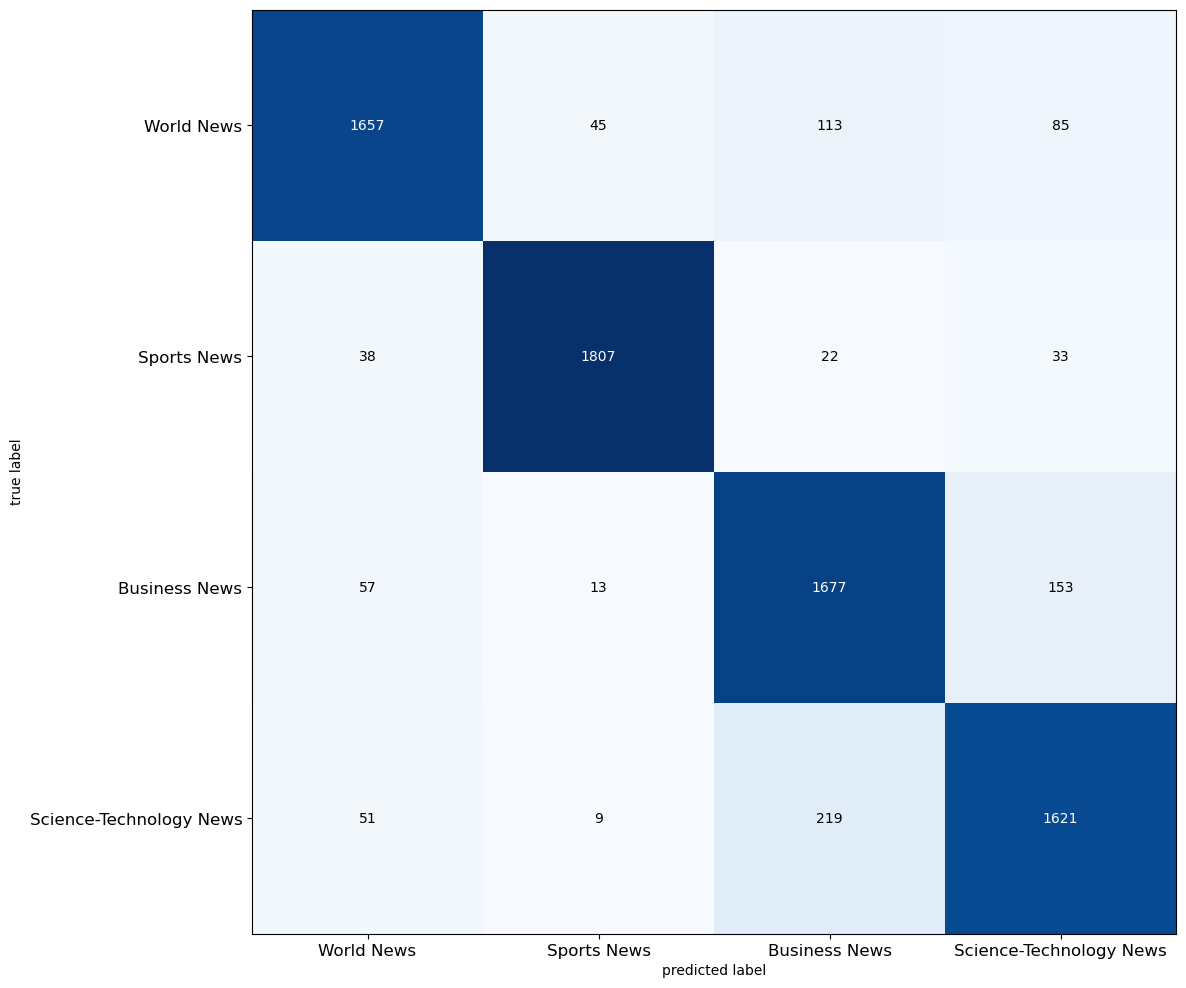

In [27]:
labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']
preds = [np.argmax(i) for i in model.predict(x_test)]
cm  = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(4), labels, fontsize=12)
plt.yticks(range(4), labels, fontsize=12)
plt.show()

In [28]:
print("Recall of the model is {:.2f}".format(recall_score(y_test, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(y_test, preds, average='micro')))
print("Accuracy of the model is {:.2f}".format(accuracy_score(y_test, preds)))

Recall of the model is 0.89
Precision of the model is 0.89
Accuracy of the model is 0.89
